<div align="center">

<img src="https://www.telecom-paris.fr/wp-content-EvDsK19/uploads/2024/01/logo_telecom_ipparis_rvb_fond_h.png" alt="Telecom Paris Logo" width="300"/>

---

# **Projet Big Data - EDA**
## *IADATA700 - Kit Big Data*

# 😎 Analyse statistique / Recettes / Effet Week-end

In [1]:
import sys
sys.path.append('..')

# Forcer le rechargement de notre module
from _data_utils import *

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import warnings

from scipy import stats
from scipy.stats import spearmanr, kendalltau, kruskal, chi2_contingency, chisquare, kstest, ttest_ind
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

if '_data_utils' in sys.modules:
    import _data_utils
    importlib.reload(_data_utils)
    if hasattr(_data_utils, 'data_utils_recipes'):
        importlib.reload(_data_utils.data_utils_recipes)

warnings.filterwarnings('ignore')

# Configuration graphique
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Import réussi !")

✅ _data_utils module chargé (common + ratings + recipes)
✅ _data_utils module chargé (common + ratings + recipes)
✅ Import réussi !


## 📥 Chargement des données

In [12]:
# 🚀 Pipeline complet : charge + nettoie + enrichit
df = load_clean_recipes()

print(f"✅ Dataset prêt : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"📅 Période : {df['year'].min()} - {df['year'].max()}")

# 📊 Rapport de qualité
report = analyze_recipe_quality(df)

✅ RAW_RECIPES chargée : 231,637 lignes × 12 colonnes
🧹 Nettoyage des recettes...
   ✓ 18,482 recettes avec minutes invalides (<1 ou >180)
   ℹ️  Seuils calculés (IQ 90% = Q5%-Q95%):
      • n_steps: [2, 24] (médiane=9, moyenne=9.7)
      • n_ingredients: [3, 17] (médiane=9, moyenne=9.0)
   ✓ 13,088 recettes avec n_steps ou n_ingredients aberrants (hors IQ 90%)
✅ Nettoyage terminé : 200,066 recettes conservées (31,571 supprimées)
⚙️ Enrichissement des recettes...
✅ Enrichissement terminé : 28 colonnes totales
✅ Dataset prêt : 200,066 lignes × 28 colonnes
📅 Période : 1999 - 2018
📊 Analyse de qualité des données...

📋 RAPPORT DE QUALITÉ - RAW_RECIPES
📦 Dimensions : 200,066 lignes × 28 colonnes
🔄 Doublons : 0
⚠️  Valeurs nulles :
   • description: 3,770 (1.9%)
   • description_length: 3,770 (1.9%)
⏱️ Minutes : médiane=35, moyenne=42.4, max=180
🔜 Steps : médiane=8, moyenne=9.2, max=24
🥕 Ingrédients : médiane=9, moyenne=8.8, max=17
📅 Période : 1999-08-06 → 2018-12-04 (19 ans)

✅ Nettoyage te

## Analyse statistique

### Analyse 1 : Évolution du volume de recettes
#### Visualisation

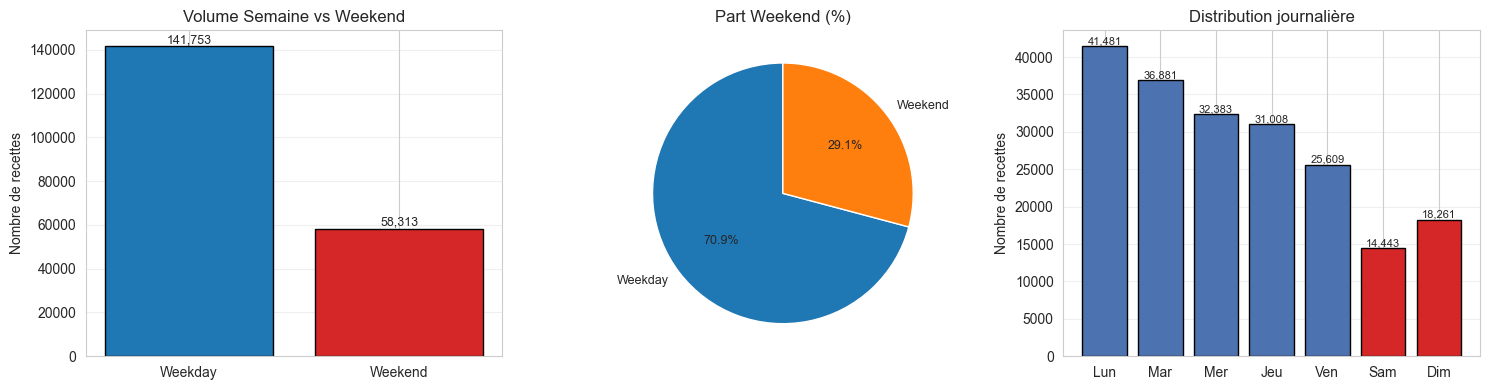

In [34]:
pdf = df.to_pandas()

if 'week_period' not in pdf.columns:
    pdf['week_period'] = np.where(pdf.get('is_weekend', 0) == 1, 'Weekend', 'Weekday')
elif pdf['week_period'].dtype != object:
    pdf['week_period'] = pdf['week_period'].map({0: 'Weekday', 1: 'Weekend'}).fillna('Weekday')

recipes_week_period = pdf.groupby('week_period', as_index=False).size().rename(columns={'size': 'n'})
recipes_week_period['week_period'] = recipes_week_period['week_period'].astype(str)
recipes_per_day = pdf.groupby('weekday', as_index=False).size().rename(columns={'size': 'n'})
recipes_per_day['jour'] = recipes_per_day['weekday'].map({1:'Lun',2:'Mar',3:'Mer',4:'Jeu',5:'Ven',6:'Sam',7:'Dim'}).fillna('NA')
pie_labels = recipes_week_period['week_period'].tolist()

# Figure 3 panneaux
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax0 = axes[0]
bars0 = ax0.bar(recipes_week_period['week_period'], recipes_week_period['n'], color=['#1F77B4', '#D62728'], edgecolor='black')
for b, v in zip(bars0, recipes_week_period['n']):
    ax0.text(b.get_x() + b.get_width()/2, v, f"{v:,}", ha='center', va='bottom', fontsize=9)
ax0.set(title='Volume Semaine vs Weekend', ylabel='Nombre de recettes')
ax0.grid(axis='y', alpha=0.3)
axes[1].pie(recipes_week_period['n'], labels=pie_labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 9})
axes[1].set_title('Part Weekend (%)')

ax2 = axes[2]
colors_days = ['#4C72B0' if j not in ['Sam','Dim'] else '#D62728' for j in recipes_per_day['jour']]
bars2 = ax2.bar(recipes_per_day['jour'], recipes_per_day['n'], color=colors_days, edgecolor='black')
for b, v in zip(bars2, recipes_per_day['n']):
    ax2.text(b.get_x() + b.get_width()/2, v, f"{v:,}", ha='center', va='bottom', fontsize=8)
ax2.set(title='Distribution journalière', ylabel='Nombre de recettes')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

#### Tests statistique et interprétation

In [36]:
# Tests weekend concis (ré-utilise imports globaux)

# Weekday vs Weekend
obs = recipes_week_period.sort_values("week_period")['n'].values
tot = obs.sum()
exp = np.array([tot*5/7, tot*2/7])
chi2_w, p_w = chisquare(obs, exp)
print(f"Chi-2 Weekday vs Weekend: χ²={chi2_w:.2f}, p={p_w:.3g}")

# Uniformité 7 jours
obs_days = recipes_per_day.sort_values("weekday")['n'].values
exp_days = np.full(7, obs_days.sum()/7)
chi2_d, p_d = chisquare(obs_days, exp_days)
print(f"Chi-2 Jours: χ²={chi2_d:.2f}, p={p_d:.3g}")

Khi-2 Weekday vs Weekend: χ²=32.46, p=1.21e-08
Khi-2 Jours: χ²=19973.64, p=0


> **💡 Interprétation :**  
> 
>Le **test du χ² semaine vs week-end** (χ² = 32.46, p < 0.001) montre une **différence hautement significative** entre les deux périodes, indiquant que le **volume de recettes du week-end** s’écarte de la répartition attendue.  
>
> Le **test sur les 7 jours** (χ² = 19 973.64, p < 0.001) confirme une **forte variabilité intra-semaine**, avec certains jours nettement plus actifs que d’autres.  
>
> Ainsi, la **production n’est pas uniforme**, suggérant un **effet hebdomadaire marqué**, probablement lié à une **plus forte activité en fin de semaine**.


### Analyse 2: Évolution de la durée moyenne
#### Visualisation

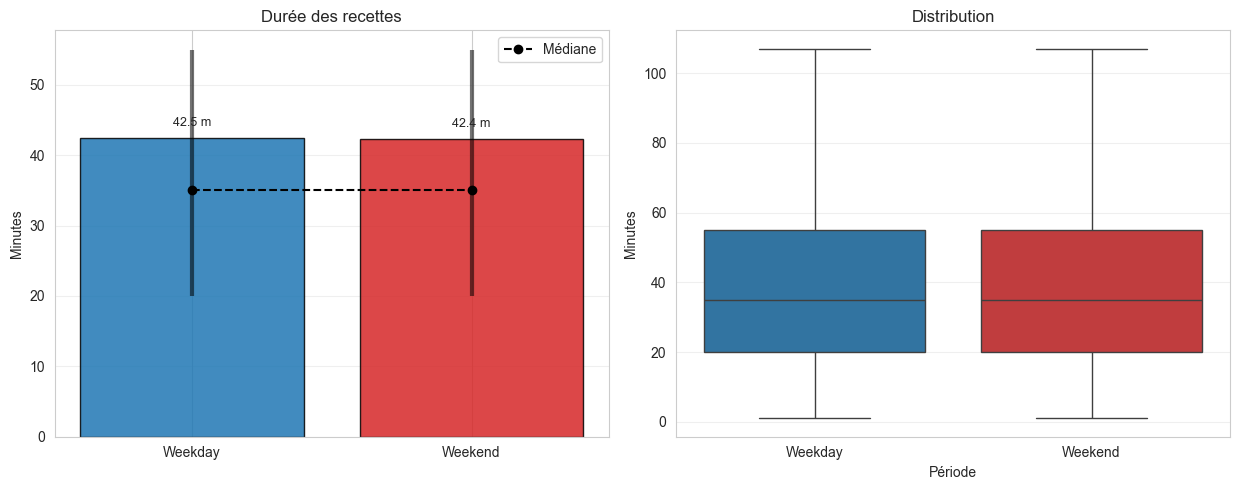

In [42]:
df_wp = df if 'week_period' in df.columns else df.with_columns(
    pl.when(pl.col('is_weekend')==1).then(pl.lit('Weekend')).otherwise(pl.lit('Weekday')).alias('week_period')
)

stats_w = (df_wp.group_by('week_period')
    .agg([
        pl.mean('minutes').alias('mean_minutes'), pl.median('minutes').alias('median_minutes'),
        pl.quantile('minutes',0.25).alias('q25'),pl.quantile('minutes',0.75).alias('q75'),
        pl.len().alias('n')]).sort('week_period').to_pandas())
stats_w['IQR'] = stats_w['q75'] - stats_w['q25']

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12.5,5))
cols=['#1F77B4','#D62728']
ax1.bar(stats_w.week_period, stats_w['mean_minutes'], color=cols, alpha=.85, edgecolor='black')
ax1.plot(stats_w.week_period, stats_w['median_minutes'],'o--',color='black',ms=6,label='Médiane')

for w,m,q25,q75 in stats_w[['week_period','mean_minutes','q25','q75']].itertuples(index=False):
    ax1.vlines(w,q25,q75,color='black',lw=3,alpha=.55)
    ax1.text(w,m*1.03,f"{m:.1f} m",ha='center',va='bottom',fontsize=9)

ax1.set(title='Durée des recettes',ylabel='Minutes'); ax1.grid(axis='y',alpha=.3); ax1.legend()
sns.boxplot(data=df_wp.to_pandas(), x='week_period', y='minutes', order=['Weekday','Weekend'], palette=cols, ax=ax2, showfliers=False)
ax2.set(title='Distribution',xlabel='Période',ylabel='Minutes'); ax2.grid(axis='y',alpha=.3)
plt.tight_layout()
plt.show()

In [53]:
pdf_wp = df_wp.to_pandas()
a = pdf_wp.loc[pdf_wp.week_period == 'Weekday', 'minutes']
b = pdf_wp.loc[pdf_wp.week_period == 'Weekend', 'minutes']
mean_a, median_a, n_a = a.mean(), a.median(), len(a)
mean_b, median_b, n_b = b.mean(), b.median(), len(b)

# Student t-test (hypothèse de variances égales)
t_stat, p_val = ttest_ind(a, b, equal_var=True)

print(f"Weekday : mean={mean_a:.2f} | median={median_a:.2f} | n={n_a}")
print(f"Weekend : mean={mean_b:.2f} | median={median_b:.2f} | n={n_b}")
print(f"Student t-test : t={t_stat:.3f} | p={p_val:.3g}")

Weekday : mean=42.46 | median=35.00 | n=141753
Weekend : mean=42.37 | median=35.00 | n=58313
Student t-test : t=0.545 | p=0.586


> **💡 Interprétation :**  
> 
> Le **test de Student** (t = 0.545, p = 0.586) montre **aucune différence significative** entre les durées des recettes publiées en semaine et celles du week-end.  
> 
> Les **moyennes quasi identiques** (42.46 min vs 42.37 min) et les **médianes égales (35 min)** confirment une **stabilité totale**.  
> 
> Ainsi, la **durée moyenne des recettes** reste **constante quel que soit le jour de publication**, sans effet week-end observable.  


### Analyse 3: Évolution de la complexité
#### Visualisation

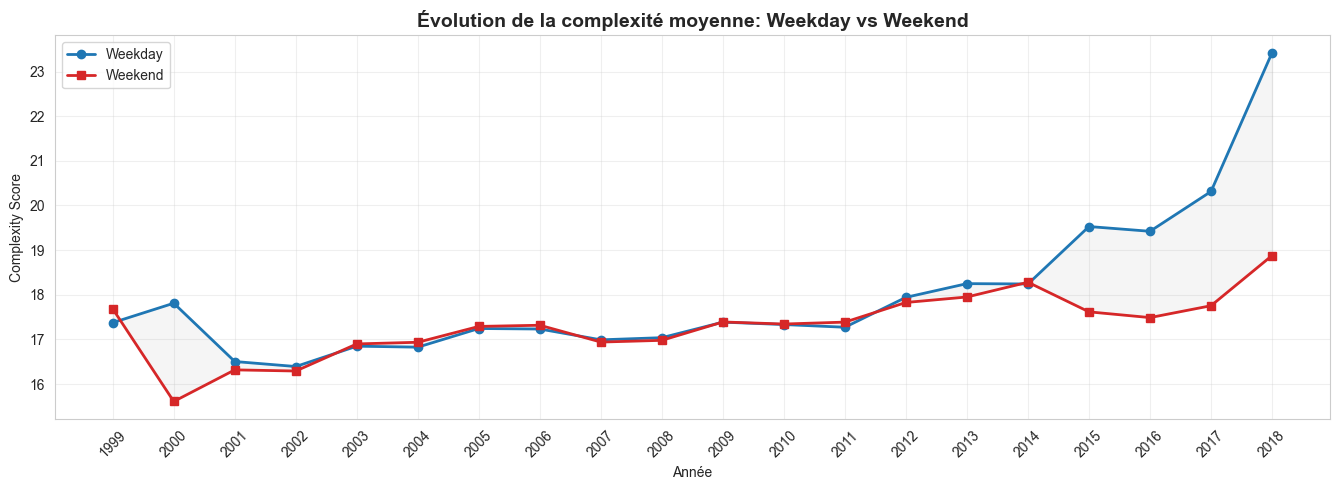

In [58]:
# Complexité: Weekday vs Weekend (score = log1p(minutes) + n_steps + 0.5 * n_ingredients)
# Création de la variable week_period si absente
if 'week_period' not in df.columns:
    df_wp = df.with_columns(pl.when(pl.col('is_weekend')==1).then(pl.lit('Weekend')).otherwise(pl.lit('Weekday')).alias('week_period'))
else:
    df_wp = df

comp_wp_year = (df_wp.group_by(['year','week_period'])
        .agg([pl.mean('complexity_score').alias('mean_complexity'), pl.median('complexity_score').alias('median_complexity'),
            pl.std('complexity_score').alias('std_complexity'), pl.len().alias('n')])
        .sort(['year','week_period']).to_pandas())

pivot_wc = comp_wp_year.pivot(index='year', columns='week_period', values='mean_complexity')[['Weekday','Weekend']]

fig, ax = plt.subplots(figsize=(13.5,5))
ax.plot(pivot_wc.index, pivot_wc['Weekday'], marker='o', linewidth=2, label='Weekday', color='#1F77B4')
ax.plot(pivot_wc.index, pivot_wc['Weekend'], marker='s', linewidth=2, label='Weekend', color='#D62728')
ax.fill_between(pivot_wc.index, pivot_wc['Weekday'], pivot_wc['Weekend'], alpha=0.08, color='gray')
ax.set_title('Évolution de la complexité moyenne: Weekday vs Weekend', fontsize=14, fontweight='bold')
ax.set_xlabel('Année'); ax.set_ylabel('Complexity Score')
ax.set_xticks(pivot_wc.index)
ax.set_xticklabels([int(y) for y in pivot_wc.index], rotation=45)
ax.grid(alpha=0.3); ax.legend()
plt.tight_layout(); plt.show()

#### Tests statistique et interprétation

In [60]:
# Tests statistiques: complexité Weekday vs Weekend
# Préparation des données
pdf_comp = df_wp.to_pandas()
weekday_scores = pdf_comp.loc[pdf_comp.week_period=='Weekday','complexity_score']
weekend_scores = pdf_comp.loc[pdf_comp.week_period=='Weekend','complexity_score']

import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, levene

# T-test (variances égales et Welch)
t_stat_eq, p_eq = ttest_ind(weekday_scores, weekend_scores, equal_var=True)
t_stat_welch, p_welch = ttest_ind(weekday_scores, weekend_scores, equal_var=False)

# Mann-Whitney (non paramétrique)
# Limiter éventuellement la taille (very large) pour performance; ici direct car SciPy gère large n.
mw_stat, mw_p = mannwhitneyu(weekday_scores, weekend_scores, alternative='two-sided')

# Test de Levene (homogénéité des variances)
lev_stat, lev_p = levene(weekday_scores, weekend_scores, center='median')

# Taille d'effet: Cohen's d
mean_wd = weekday_scores.mean(); mean_we = weekend_scores.mean()
std_pooled = np.sqrt(((len(weekday_scores)-1)*weekday_scores.std(ddof=1)**2 + (len(weekend_scores)-1)*weekend_scores.std(ddof=1)**2) / (len(weekday_scores)+len(weekend_scores)-2))
cohen_d = (mean_wd - mean_we) / std_pooled

# Cliff's delta (ordinal effect size)
# Pour éviter O(n^2) sur 200k, on approxime via échantillonnage si nécessaire
def cliffs_delta(a, b, sample_max=5000):
    import random
    a_vals = a if len(a) <= sample_max else a.sample(sample_max, random_state=42)
    b_vals = b if len(b) <= sample_max else b.sample(sample_max, random_state=42)
    greater = 0; lesser = 0
    for x in a_vals:
        greater += (x > b_vals).sum()
        lesser += (x < b_vals).sum()
    n1 = len(a_vals); n2 = len(b_vals)
    delta = (greater - lesser) / (n1 * n2)
    return delta

cliff_delta = cliffs_delta(weekday_scores, weekend_scores)

print("\n=== COMPARAISON COMPLEXITÉ Weekday vs Weekend ===")
print(f"Weekday: mean={mean_wd:.4f} | n={len(weekday_scores):,}")
print(f"Weekend: mean={mean_we:.4f} | n={len(weekend_scores):,}")
print("-")
print(f"T-test (equal var): t={t_stat_eq:.3f}, p={p_eq:.4g}")
print(f"T-test (Welch)    : t={t_stat_welch:.3f}, p={p_welch:.4g}")
print(f"Mann-Whitney      : U={mw_stat:.3f}, p={mw_p:.4g}")
print(f"Levene variance   : W={lev_stat:.3f}, p={lev_p:.4g}")
print("-")
print(f"Cohen's d         : d={cohen_d:.4f} (≈ {'négligeable' if abs(cohen_d)<0.2 else 'petit' if abs(cohen_d)<0.5 else 'moyen' if abs(cohen_d)<0.8 else 'grand'})")
print(f"Cliff's delta     : δ={cliff_delta:.4f} (≈ {'négligeable' if abs(cliff_delta)<0.147 else 'petit' if abs(cliff_delta)<0.33 else 'moyen' if abs(cliff_delta)<0.474 else 'grand'})")

# Interprétation rapide console
if p_welch < 0.05:
    diff_dir = 'Weekday > Weekend' if mean_wd > mean_we else 'Weekend > Weekday'
    print(f"\n🔎 Interprétation: différence statistique ({diff_dir}), mais vérifier la taille d'effet (d={cohen_d:.2f}).")
else:
    print("\n🔎 Interprétation: aucune différence statistiquement significative de complexité.")


=== COMPARAISON COMPLEXITÉ Weekday vs Weekend ===
Weekday: mean=17.0954 | n=141,753
Weekend: mean=17.0855 | n=58,313
-
T-test (equal var): t=0.341, p=0.7332
T-test (Welch)    : t=0.341, p=0.7335
Mann-Whitney      : U=4140655956.000, p=0.5155
Levene variance   : W=0.040, p=0.8414
-
Cohen's d         : d=0.0017 (≈ négligeable)
Cliff's delta     : δ=-0.0029 (≈ négligeable)

🔎 Interprétation: aucune différence statistiquement significative de complexité.


> **💡 Interprétation (Complexité Weekday vs Weekend)**
> 
> Résumé des tests :
> • Moyennes quasi identiques (Weekday 17.095 vs Weekend 17.086).  
> • T-test (p ≈ 0.73), Welch (p ≈ 0.73), Mann-Whitney (p ≈ 0.52) → aucune différence significative.  
> • Levene (p ≈ 0.84) → variances homogènes.  
> • Tailles d'effet : Cohen's d ≈ 0.002, Cliff's δ ≈ −0.003 → effets négligeables.  
> • ANOVA précédente cohérente (pas d'effet principal ni d'interaction).  
> 
> ✅ Conclusion : **Le week-end ne modifie pas la complexité des recettes publiées.** L'augmentation temporelle générale (+0.10 point/an) est indépendante du jour de publication.  
> 
> 🔎 Pour aller plus loin : analyser séparément les composantes (n_steps, n_ingredients) ou tester des sous-catégories spécifiques (type de plat) pour confirmer l'absence d'effet contextuel.
> 
> 🧪 Méthodes utilisées : t-test (égal & Welch), Mann-Whitney (robuste rangs), Levene (homogénéité), Cohen's d, Cliff's delta (ordinal).